In [1]:
projectdir = joinpath(Base.homedir(), "sciebo/Master/Workspace/Julia_Master/MasterProject_Julia")
cd(projectdir)
using Pkg; Pkg.activate(pwd())

using DataFrames, StatsBase, Plots, Statistics, LaTeXStrings, LsqFit, CSV, Pipe, ProgressMeter, StatsPlots, BSON
using Distributions, NLsolve, Roots, Random
pyplot()

try
    Turnover
catch e
    include(joinpath(projectdir,"Turnover/src/Turnover.jl"))
    include(joinpath(projectdir,"Turnover/src/test.jl"))
    using .Turnover
end
try
    SeqDataFormatting
catch e
    include("experimental_data/SeqDataFormatting.jl")
    import .SeqDataFormatting
end
include("experimental_data/lichee_cloneclustering.jl")

include("scripts/distribution_functions.jl")
import TumorGrowth
plot(size=(1,1))

  Activating environment at `C:\Users\ArmanAngaji\sciebo\Master\Workspace\Julia_Master\MasterProject_Julia\Project.toml`
┌ Info: Precompiling TumorGrowth [6c18b9fe-b06a-4315-99c1-34a00b453ec5]
└ @ Base loading.jl:1317


Loading Packages... Done!
Test Summary:             | Pass  Total
Applying turnover methods |    7      7


# Ling data

In [2]:
sanger = TumorGrowth.data_import("experimental_data/Ling/Ling_data_sanger.csv"; delim="\t")
sanger.frequencies = [ones(Float64, length(m)) for m in sanger.mutations];

In [3]:
wes = TumorGrowth.data_import("experimental_data/Ling/Ling_data_wes.csv", delim="\t");

In [21]:
sanger_lichee = TumorGrowth.data_import("experimental_data\\Ling\\Ling_data_sanger_clones_lichee.csv", delim="\t")
lichee_tree = BSON.load("experimental_data\\Ling\\lichee_tree_Sanger.bson")
sanger_lichee.frequencies = map( ones∘length, sanger_lichee.mutations)

sanger_coinc = TumorGrowth.data_import("experimental_data\\Ling\\Ling_data_sanger_clones_coinc.csv", delim="\t")

# filter!.(m -> !(m in [12,13,14,26,27,28,29]), sanger_coinc.mutations)

sanger_coinc.frequencies = map( ones∘length, sanger_coinc.mutations)
;

In [12]:
sanger_coinc = coincidence_clustering_clonetumor(sanger)
sanger_coinc.mutations |> unique |> sort

23-element Vector{Vector{Int64}}:
 []
 [1, 2]
 [3]
 [3, 4]
 [3, 5]
 [6]
 [6, 7]
 [6, 7, 8]
 [6, 7, 9]
 [10]
 [10, 11]
 [15, 16]
 [15, 16, 17]
 [15, 16, 17, 18]
 [15, 16, 19, 20, 21]
 [22]
 [23, 24]
 [23, 24, 25]
 [30]
 [30, 31]
 [30, 31, 32]
 [30, 33, 34]
 [30, 35]

In [96]:
n = nrow(sanger)
min_samples = 2
N = n^(3/2) * 2/(π^(1/2)*3^(1/4)) / min_samples
println(N)

# turnover_params = ( f_min = 1/20, Nthresh_orph = 95, Nthresh_estr = 95, )
turnover_params = ( f_min = min_samples, Nthresh_orph = N, Nthresh_estr = N, )

freqs = SeqDataFormatting.mfreqs(wes) |> df -> Dict(df.mutation .=> df.frequency)
samplecounts = TumorGrowth.mutation_freqs(sanger) |> df -> Dict(df.mutation .=> df.reads)

# tumor = deepcopy(sanger_lichee)
tumor = deepcopy(sanger_coinc)
# tumor = deepcopy(sanger);

2062.585878311575


In [7]:
# ds = map( 0.5:0.1:1. ) do L
#     map( 1:100 ) do _
#         orphaned_tumor = DataFrame( mutations = unique( 
#                 filter.(m-> samplecounts[m] > turnover_params[:f_min], tumor.mutations) ) )
#         orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)

#         # get d
#         W_l = orphaned_red_treeless(orphaned_tumor) |> 
#             df -> sum( df.isorphaned ) / sum( df.isgreen )

#         d_solve = try
#             fzero(x -> min(1., Turnover.W_orphaned( x;
#                         N= turnover_params[:Nthresh_orph]*(1-x))) - W_l, 0.001, 0.999)
#         catch e
#             e isa ArgumentError && NaN
#         end
#     end
# end
# filter!.(!isnan, ds)
# ds = vcat(ds...)
# d_solve = median(ds)

# estranged_tumor = DataFrame(mutations = filter( muts -> all(  samplecounts[m] > turnover_params[:f_min] for m in muts), tumor.mutations) )
# # get mu
# W_c = estranged_treeless(estranged_tumor) |> df -> sum( df.isestranged ) / sum( df.isgreen ) #|> mes2theory_estranged

# # mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
# mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu,
#             T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, 0.001, 0.999)

# Ls = 0.4:0.1:1.
# reps = 300
# estranged_tumors = map( Ls ) do L
#     [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
# end

# estranged_turnover = map(estranged_tumors) do set
#         filter!(!isnan, set .|> estranged_treeless .|> df -> sum( df.isestranged ) / sum( df.isgreen ))
#     end

# Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

# function model(Ls, p)
#     local mu = p[1]
#     (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
#     map( Ls ) do L
#         min(1., W_estranged(d_solve; b=1., μ=mu*L,
#                 T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))
#     end
# end
# # fitres = curve_fit(model, Ls, mean.(t), [(1-d_solve)/2])
# fitres = curve_fit(model, vcat( [ fill(Ls[i], length(t_)) for (i,t_) in enumerate(t)]... ), 
#     vcat(t...), [(1-d_solve)/2])
# mu_fit = fitres.param[1]

# tvecs = [ rand.(t) for _=1:10000 ]
# fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
# mu_fits = getindex.(getfield.(fits, :param),1);

In [97]:
Random.seed!(1122)
ds = []
mus = []
Ls = []
@showprogress for L in 0.5:0.1:1.
    for _ in 1:50
        try         
            orphaned_tumor = DataFrame( mutations = unique( 
                    filter.(m-> samplecounts[m] > turnover_params[:f_min], tumor.mutations)
                ))
            orphaned_tumor = TumorGrowth.reduced_mu(orphaned_tumor, L)
            
            estranged_tumor = DataFrame(mutations = unique(
                    filter( muts -> all(  samplecounts[m] > turnover_params[:f_min] for m in muts),
                    tumor.mutations)
                ))
            estranged_tumor = TumorGrowth.reduced_mu(estranged_tumor, L)

            # get d
            W_l = orphaned_red_treeless(orphaned_tumor) |> 
                df -> sum( df.isorphaned ) / sum( df.isgreen )
            
            d_solve = fzero(x -> min(1., Turnover.W_orphaned( x;
                            N= turnover_params[:Nthresh_orph]*(1-x))) - W_l, 0.001, 0.999)
            
            # get mu
            W_c = estranged_treeless(estranged_tumor) |> df -> sum( df.isestranged ) / sum( df.isgreen )
            
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu*L,
                T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, 0.001, 4.)
            if 0.001 < d_solve < 0.999 #&& 0.001 < mu_solve < 0.999
                push!( ds, d_solve)
                push!(mus, mu_solve)
                push!(Ls, L)
            end
        catch e
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [103]:
path = joinpath(projectdir, "Turnover", "turnover_data", "Ling_inference_results_coinc.bson")

# SAVE RESULTS

# bson(path, 
#     Dict( "data" => "Ling", "clustering"=>"coinc", "min_samples"=>min_samples, "N"=>N,
#         "ds"=>ds, "mus"=>mus, "subsampling_rate_L"=>Ls)
#     )

# LOAD RESULTS

results = BSON.load(path)
ds, mus, Ls = results["ds"], results["mus"], results["subsampling_rate_L"];

In [23]:
Random.seed!(1122)
ds = []
mus = []
@showprogress for L in 0.5:0.1:1.
    
    tumors = map( 1:50 ) do _
        orphaned_tumor = DataFrame( mutations = unique( 
            filter.(m-> samplecounts[m] > turnover_params[:f_min], tumor.mutations)
        ))
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)
        estranged_tumor = DataFrame(mutations = unique(
                filter( muts -> all(  samplecounts[m] > turnover_params[:f_min] for m in muts),
                tumor.mutations)
            ))
        estranged_tumor = TumorGrowth.reduced_μ(estranged_tumor, L)
        
        orphaned_tumor, estranged_tumor
    end
    
    unique!(tumors)
    
    for (orphaned_tumor, estranged_tumor) in tumors
        try         
            # get d
            W_l = orphaned_red_treeless(orphaned_tumor) |> 
                df -> sum( df.isorphaned ) / sum( df.isgreen )
            
            d_solve = fzero(x -> min(1., Turnover.W_orphaned( x;
                            N= turnover_params[:Nthresh_orph]*(1-x))) - W_l, 0.001, 0.999)
            
            # get mu
            W_c = estranged_treeless(estranged_tumor) |> df -> sum( df.isestranged ) / sum( df.isgreen )
            
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu*L,
                T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, 0.001, 0.999)
            
            push!( ds, d_solve)
            push!(mus, mu_solve)
        catch e
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [7]:
last( ds), last( mus)

(0.9759913779153895, 0.015224681980724745)

## *lichee clustering*

> min_samples = 2

0.9942805101515869
0.0017406875762587127


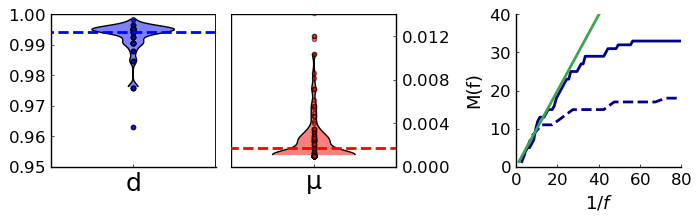

In [120]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.95, 1.0)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black)
vline!(p[1], [xlim[2]], c=:black, lw=2)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 0.014)
yticks = range(ylim..., step=0.004)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black)
vline!(p[2], [xlim[1]], c=:black)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
M!(p[end], TumorGrowth.mutation_freqs(sanger).frequency, nbins=50, lab="sanger", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="")

# mean

0.9942805101515869
0.0017406875762587127


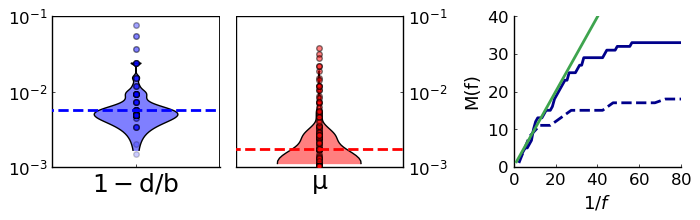

In [145]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"1-d/b"]), yscale=:log10)
hline!(p[1], [ylim[2]], c=:black)
vline!(p[1], [xlim[2]], c=:black, lw=2)
violin!(p[1], [1], 1 .- ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], 1 .- ds, c=:blue, alpha=0.2, ms = 4)
hline!(p[1], [median(1 .- ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"\mu"]), ymirror=true, yscale=:log10)
hline!(p[2], [ylim[2]], c=:black)
vline!(p[2], [xlim[1]], c=:black)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.95), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 4)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
M!(p[end], TumorGrowth.mutation_freqs(sanger).frequency, nbins=50, lab="sanger", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="")

# mean

0.9926555374846471
0.0026431110794263857


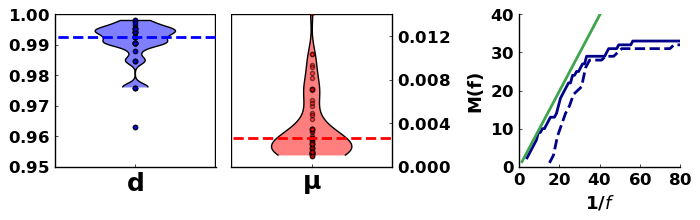

In [17]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.95, 1.0)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 0.014)
yticks = range(ylim..., step=0.004)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)

mutations = SeqDataFormatting.mfreqs(wes)
mutations.frequency .= 0
mutations.purity = ones(nrow(mutations))
mutations.sample = zeros(Int,nrow(mutations))

mut2ind = Dict( mutations.mutation .=> 1:nrow(mutations))
for (n,row) in enumerate(eachrow(wes))
    for (m,f) in zip(row.mutations, row.frequencies)
        i = mut2ind[m]
        if mutations.frequency[i] < f
            mutations.frequency[i] = f
            mutations.purity[i] = row.purity
            mutations.sample[i] = n
        end
    end
end

M!(p[end], (mutations.frequency .* mutations.purity) ./ sum(wes.purity), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="")

# mean

0.9926555374846471
0.0026431110794263857


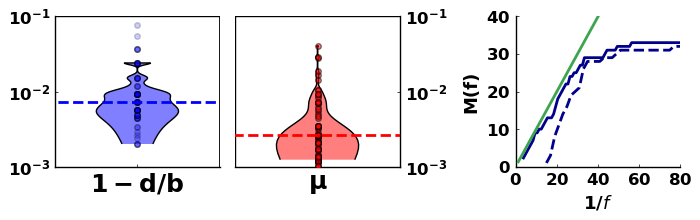

In [19]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"1-d/b"]), yscale=:log10)
hline!(p[1], [ylim[2]], c=:black)
vline!(p[1], [xlim[2]], c=:black, lw=2)
violin!(p[1], [1], 1 .- ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], 1 .- ds, c=:blue, alpha=0.2, ms = 4)
hline!(p[1], [median(1 .- ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"\mu"]), ymirror=true, yscale=:log10)
hline!(p[2], [ylim[2]], c=:black)
vline!(p[2], [xlim[1]], c=:black)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.95), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 4)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)

mutations = SeqDataFormatting.mfreqs(wes)
mutations.frequency .= 0
mutations.purity = ones(nrow(mutations))
mutations.sample = zeros(Int,nrow(mutations))

mut2ind = Dict( mutations.mutation .=> 1:nrow(mutations))
for (n,row) in enumerate(eachrow(wes))
    for (m,f) in zip(row.mutations, row.frequencies)
        i = mut2ind[m]
        if mutations.frequency[i] < f
            mutations.frequency[i] = f
            mutations.purity[i] = row.purity
            mutations.sample[i] = n
        end
    end
end

M!(p[end], (mutations.frequency .* mutations.purity) ./ sum(wes.purity), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="")

# mean

In [20]:
# name = "Ling_lichee"
# savefig("Turnover\\turnover_plots\\experimental_data\\"* name * ".pdf")
# savefig("Turnover\\turnover_plots\\experimental_data\\"* name * ".png")

> min_samples = 4

0.9932125831160558
0.001479522542463045


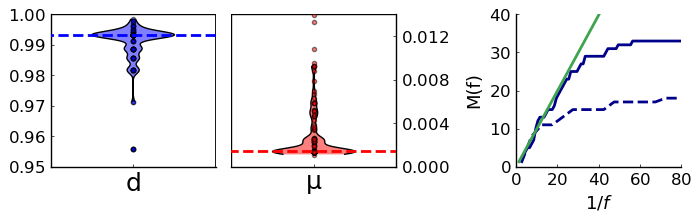

In [129]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.95, 1.0)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black)
vline!(p[1], [xlim[2]], c=:black, lw=2)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 0.014)
yticks = range(ylim..., step=0.004)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black)
vline!(p[2], [xlim[1]], c=:black)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
M!(p[end], TumorGrowth.mutation_freqs(sanger).frequency, nbins=50, lab="sanger", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="")

# mean

0.9932125831160558
0.001479522542463045


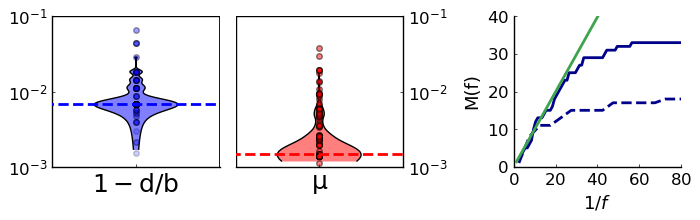

In [142]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"1-d/b"]), yscale=:log10)
hline!(p[1], [ylim[2]], c=:black)
vline!(p[1], [xlim[2]], c=:black, lw=2)
violin!(p[1], [1], 1 .- ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], 1 .- ds, c=:blue, alpha=0.2, ms = 4)
hline!(p[1], [median(1 .- ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"\mu"]), ymirror=true, yscale=:log10)
hline!(p[2], [ylim[2]], c=:black)
vline!(p[2], [xlim[1]], c=:black)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.95), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 4)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
M!(p[end], TumorGrowth.mutation_freqs(sanger).frequency, nbins=50, lab="sanger", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="")

# mean

0.9887235266475548
0.003467289099069317


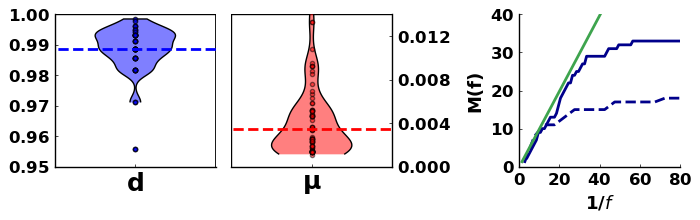

In [57]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.95, 1.0)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black)
vline!(p[1], [xlim[2]], c=:black, lw=2)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 0.014)
yticks = range(ylim..., step=0.004)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black)
vline!(p[2], [xlim[1]], c=:black)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
M!(p[end], TumorGrowth.mutation_freqs(sanger).frequency, nbins=50, lab="sanger", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="")

# mean

0.9887235266475548
0.003467289099069317


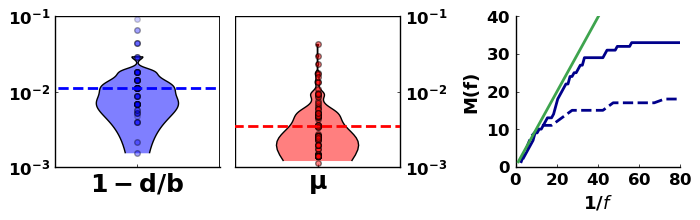

In [58]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"1-d/b"]), yscale=:log10)
hline!(p[1], [ylim[2]], c=:black)
vline!(p[1], [xlim[2]], c=:black, lw=2)
violin!(p[1], [1], 1 .- ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], 1 .- ds, c=:blue, alpha=0.2, ms = 4)
hline!(p[1], [median(1 .- ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"\mu"]), ymirror=true, yscale=:log10)
hline!(p[2], [ylim[2]], c=:black)
vline!(p[2], [xlim[1]], c=:black)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.95), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 4)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
M!(p[end], TumorGrowth.mutation_freqs(sanger).frequency, nbins=50, lab="sanger", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="")

# mean

> min_samples = 10

0.9919241744082749
0.0022130872853772794


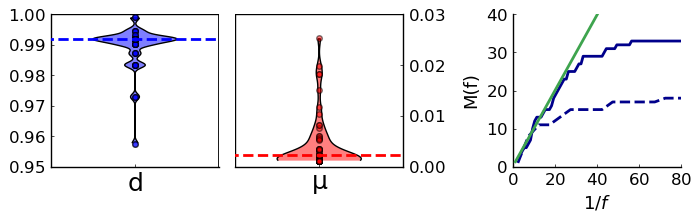

In [39]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.95, 1.0)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black)
vline!(p[1], [xlim[2]], c=:black, lw=2)
violin!(p[1], [1], ds, c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0, 0.03)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black)
vline!(p[2], [xlim[1]], c=:black)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.95), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
M!(p[end], TumorGrowth.mutation_freqs(sanger).frequency, nbins=50, lab="sanger", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="")

# mean

0.9919241744082749
0.0022130872853772794


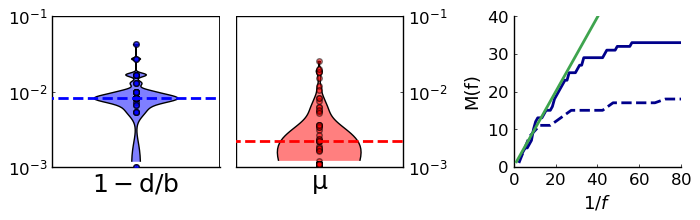

In [40]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"1-d/b"]), yscale=:log10)
hline!(p[1], [ylim[2]], c=:black)
vline!(p[1], [xlim[2]], c=:black, lw=2)
violin!(p[1], [1], 1 .- ds, c=:blue, fillalpha=0.5)
scatter!(p[1], [1], 1 .- ds, c=:blue, alpha=0.5)
hline!(p[1], [median(1 .- ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"\mu"]), ymirror=true, yscale=:log10)
hline!(p[2], [ylim[2]], c=:black)
vline!(p[2], [xlim[1]], c=:black)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.95), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
M!(p[end], TumorGrowth.mutation_freqs(sanger).frequency, nbins=50, lab="sanger", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="")

# mean

0.9902292686283763
0.0035773309022603273


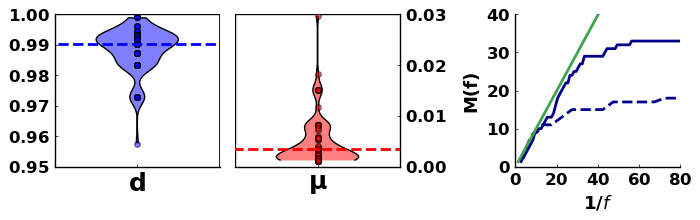

In [61]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.95, 1.0)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black)
vline!(p[1], [xlim[2]], c=:black, lw=2)
violin!(p[1], [1], ds, c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0, 0.03)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black)
vline!(p[2], [xlim[1]], c=:black)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.95), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
M!(p[end], TumorGrowth.mutation_freqs(sanger).frequency, nbins=50, lab="sanger", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="")

# mean

0.9902292686283763
0.0035773309022603273


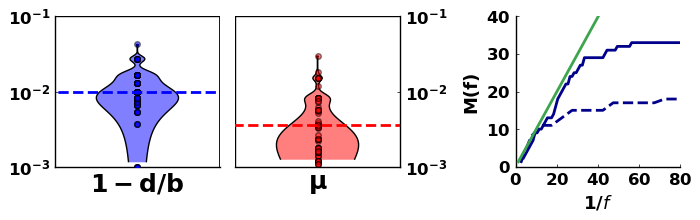

In [62]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"1-d/b"]), yscale=:log10)
hline!(p[1], [ylim[2]], c=:black)
vline!(p[1], [xlim[2]], c=:black, lw=2)
violin!(p[1], [1], 1 .- ds, c=:blue, fillalpha=0.5)
scatter!(p[1], [1], 1 .- ds, c=:blue, alpha=0.5)
hline!(p[1], [median(1 .- ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"\mu"]), ymirror=true, yscale=:log10)
hline!(p[2], [ylim[2]], c=:black)
vline!(p[2], [xlim[1]], c=:black)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.95), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
M!(p[end], TumorGrowth.mutation_freqs(sanger).frequency, nbins=50, lab="sanger", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="")

# mean

In [181]:
L = 1270015
muL = 0.002
mu = muL / L

1.5747845497887821e-9

## *simple/coincidence clustering*

> min_samples = 2

0.9759913779153895
0.015224681980724745


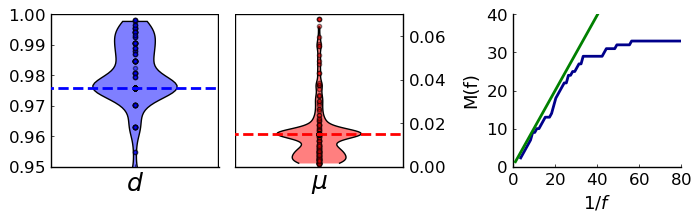

In [7]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.95, 1.0)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 0.07)
yticks = range(ylim..., step=0.02)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

# mutations = SeqDataFormatting.mfreqs(wes)
# mutations.frequency .= 0
# mutations.purity = ones(nrow(mutations))
# mutations.sample = zeros(Int,nrow(mutations))

# mut2ind = Dict( mutations.mutation .=> 1:nrow(mutations))
# for (n,(row, row_)) in enumerate(zip(eachrow(wes), eachrow(wes_nomigs)))
#     for (m,f) in zip(row.mutations, row.frequencies)
#         i = mut2ind[m]
#         if mutations.frequency[i] < f
#             mutations.frequency[i] = f
#             mutations.purity[i] = row.purity
#             mutations.sample[i] = n
#         end
#     end
# end

# M!(p[end], (mutations.frequency .* mutations.purity) ./ sum(wes.purity), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
#     lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)

In [8]:
name = "Ling_coinc"
# savefig("Turnover\\turnover_plots\\experimental_data\\"* name * ".pdf")
# savefig("Turnover\\turnover_plots\\experimental_data\\"* name * ".png")

0.5: 0.9906072017368108
0.5: 0.007939829223820047
0.6: 0.9541771344049408
0.6: 0.032455229155325005
0.7: 0.9784245764015624
0.7: 0.017389496367223124
0.8: 0.9759913779153895
0.8: 0.011487628533056323
0.9: 0.9759913779153895
0.9: 0.014443652207195307
1.0: 0.9759913779153895
1.0: 0.015224681980724741


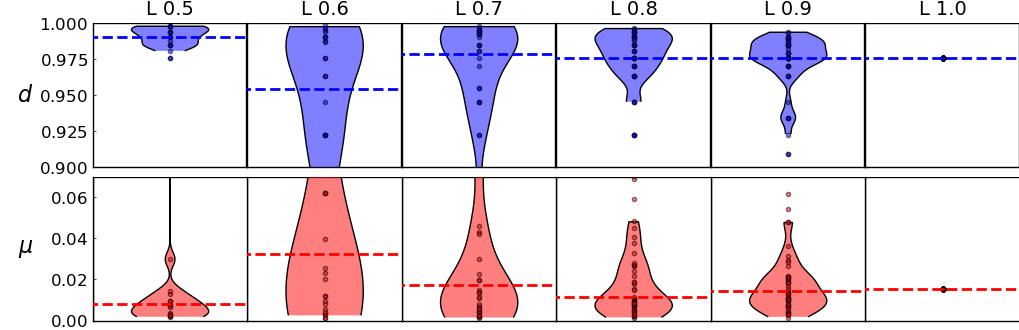

In [89]:
L_unique=unique(Ls)

p = plot(layout=(2,length(L_unique)), size=(length(L_unique)*170, 330), 
    legend=:none, grid=false, ytickfontsize=12, margin=0Plots.mm, xticks=:none, ylabelfontsize=16, yguidefontrotation=-90)
annotate!(p[1,1], -.5, .95, (L"d", 16), leftmargin=10Plots.mm,)
annotate!(p[2,1], -.5, .035, (L"\mu", 16), leftmargin=10Plots.mm,)

for (i,L) in enumerate(L_unique)
    mask = Ls .== L
    
    ds_, mus_ = ds[[mask]...], mus[[mask]...]
    plot!(p[1,i], title="L $L")

    ylim = (0.9, 1.0)
    xlim = (0.2, 1.8)
    plot!(p[1,i], legend=:none, xlim=xlim, ylim=ylim)
    hline!(p[1,i], [ylim[2]], c=:black, lw=1.7)
    vline!(p[1,i], [xlim[2]], c=:black, lw=1.7)
    if L < 1.
        violin!(p[1,i], [1], ds_[ ds_ .> quantile(ds_, 0.1)], c=:blue, fillalpha=0.5)
    elseif L == 1.
        violin!(p[1,i], [1], ds_, c=:blue, fillalpha=0.5)
    end
    scatter!(p[1,i], [1], ds_, c=:blue, alpha=0.5, ms = 3)
    hline!(p[1,i], [median(ds_)], c=:blue, lw=2., style=:dash)
    println(L, ": ", median(ds_))
    i>1 && plot!(p[1,i], yticks=:none)

    xlim = (0.2, 1.8)
    ylim = (0.0, 0.07)
    yticks = range(ylim..., step=0.02)
    plot!(p[2,i], legend=:none, xlim=xlim, ylim=ylim, yticks=yticks)
    hline!(p[2,i], [ylim[2]], c=:black, lw=1.7)
    vline!(p[2,i], [xlim[1]], c=:black, lw=1.7)
    if L < 1.
        violin!(p[2,i], [1], mus_[ mus_ .< quantile(mus_, 0.9)], c=:red, fillalpha=0.5)
    elseif L == 1.
        violin!(p[2,i], [1], mus_, c=:red, fillalpha=0.5)
    end
    scatter!(p[2,i], [1], mus_, c=:red, alpha=0.5, ms = 3)
    hline!(p[2,i], [median(mus_)], c=:red, lw=2., style=:dash)
    println(L, ": ", median(mus_))
    i>1 && plot!(p[2,i], yticks=:none)
end
p

In [90]:
name = "Ling_coinc_subsample"
# savefig("Turnover\\turnover_plots\\experimental_data\\"* name * ".pdf")
# savefig("Turnover\\turnover_plots\\experimental_data\\"* name * ".png")

In [11]:
quantile(ds,0.025), median(ds),  quantile(ds,0.975)

(0.7701673928479229, 0.9759913779153895, 0.9965818335189628)

In [12]:
quantile(ds,0.05), median(ds),  quantile(ds,0.95)

(0.8338462491493092, 0.9759913779153895, 0.9955660960907841)

In [43]:
mean(ds), std(ds)/sqrt(length(ds))

(0.9588613221304557, 0.0036696023226300916)

$0.865$ < $0.975$ < $0.996$

In [10]:
quantile(mus,0.025), median(mus), quantile(mus,0.975)

(0.001581549259960685, 0.015224681980724745, 0.14118569793382144)

In [13]:
quantile(mus,0.05), median(mus), quantile(mus,0.95)

(0.0017406875762587127, 0.015224681980724745, 0.10194434723894953)

In [14]:
mean(mus), std(mus)/sqrt(length(mus))

(0.023434025539819586, 0.0022527288585627936)

$1.7\cdot 10^{-3}$ < $1.5\cdot 10^{-2}$ < $1.0\cdot 10^{-1}$

In [15]:
L = 480363
( quantile(mus,0.025), median(mus), quantile(mus,0.975) ) ./ L

(3.292404410749131e-9, 3.169411878251394e-8, 2.9391459778088954e-7)

In [18]:
L = 480363
( quantile(mus,0.05), median(mus), quantile(mus,0.95) ) ./ L

(3.623692033438697e-9, 3.169411878251394e-8, 2.122235626785359e-7)

In [21]:
mean(mus/L), std(mus/L)/sqrt(length(mus))

(4.878399364609573e-8, 4.68963858282756e-9)

$3.6\cdot 10^{-9}$ < $3.2\cdot 10^{-8}$ < $2.1\cdot 10^{-7}$

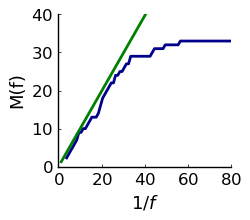

In [13]:
p = plot(layout=(1,1), size=(250,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

# ylim = (0.95, 1.0)
# xlim = (0.2, 1.8)
# plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
# hline!(p[1], [ylim[2]], c=:black, lw=1.7)
# vline!(p[1], [xlim[2]], c=:black, lw=1.7)
# violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
# scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
# hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
# println(median(ds))

# xlim = (0.2, 1.8)
# ylim = (0.0, 0.07)
# yticks = range(ylim..., step=0.02)
# plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
# hline!(p[2], [ylim[2]], c=:black, lw=1.7)
# vline!(p[2], [xlim[1]], c=:black, lw=1.7)
# violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
# scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
# hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
# println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

In [10]:
name = "Ling_coinc_sottoriva"
savefig("Turnover\\turnover_plots\\experimental_data\\"* name * ".pdf")
savefig("Turnover\\turnover_plots\\experimental_data\\"* name * ".png")

0.02400862208461052
0.015224681980724745


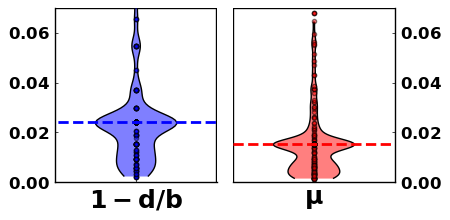

In [18]:
p = plot(layout=(1,2), size=(450,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0, 0.07)
xlim = (0.2, 1.8)
yticks = range(ylim..., step=0.02)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, yticks=yticks, ylim=ylim, xticks=([1],[L"1 - d/b"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], 1 .- ds[ 1 .- ds .< quantile(1 .- ds, 0.95)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], 1 .- ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(1 .- ds)], c=:blue, lw=2., style=:dash)
println(median(1 .- ds))

xlim = (0.2, 1.8)
ylim = (0.0, 0.07)
yticks = range(ylim..., step=0.02)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))
p

# res = 1/80
# plot!(p[end], tickfontsize=12, labelfontsize=13)
# M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
#     lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
# M!(p[end], TumorGrowth.mutation_freqs(sanger).frequency, nbins=50, lab="sanger", xlab=L"1/f", ylab=L"M(f)",
#     lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)
# plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="")

0.9759913779153895
0.015224681980724745


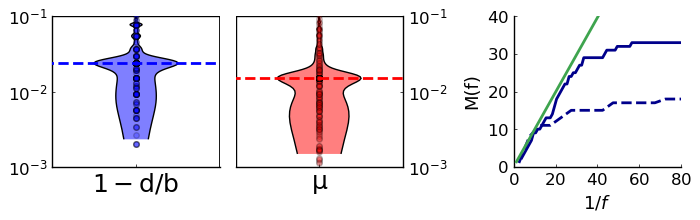

In [21]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"1-d/b"]), yscale=:log10)
hline!(p[1], [ylim[2]], c=:black)
vline!(p[1], [xlim[2]], c=:black, lw=2)
violin!(p[1], [1], 1 .- ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], 1 .- ds, c=:blue, alpha=0.2, ms = 4)
hline!(p[1], [median(1 .- ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"\mu"]), ymirror=true, yscale=:log10)
hline!(p[2], [ylim[2]], c=:black)
vline!(p[2], [xlim[1]], c=:black)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.95), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.2, ms = 4)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
M!(p[end], TumorGrowth.mutation_freqs(sanger).frequency, nbins=50, lab="sanger", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="")

# mean

0.9759913779153895
0.015224681980724745


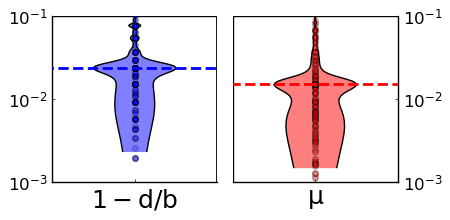

In [28]:
p = plot(layout=(1,2), size=(450,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"1-d/b"]), yscale=:log10)
hline!(p[1], [ylim[2]], c=:black)
vline!(p[1], [xlim[2]], c=:black, lw=2)
violin!(p[1], [1], 1 .- ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], 1 .- ds, c=:blue, alpha=0.2, ms = 4)
hline!(p[1], [median(1 .- ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"\mu"]), ymirror=true, yscale=:log10)
hline!(p[2], [ylim[2]], c=:black)
vline!(p[2], [xlim[1]], c=:black)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.95), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.2, ms = 4)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))
p

0.9759913779153895
0.012048277297523129


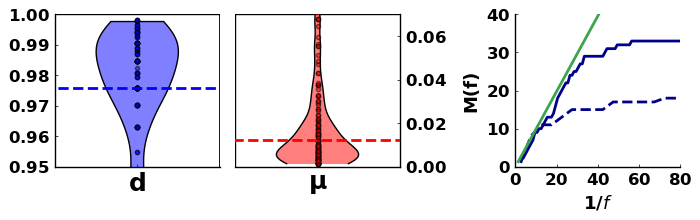

In [65]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.95, 1.0)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black)
vline!(p[1], [xlim[2]], c=:black, lw=2)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 0.07)
yticks = range(ylim..., step=0.02)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black)
vline!(p[2], [xlim[1]], c=:black)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
M!(p[end], TumorGrowth.mutation_freqs(sanger).frequency, nbins=50, lab="sanger", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="")

# mean

0.9759913779153895
0.012048277297523129


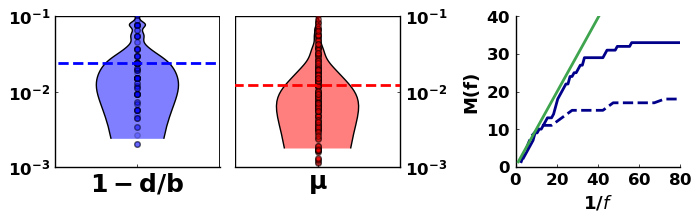

In [66]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"1-d/b"]), yscale=:log10)
hline!(p[1], [ylim[2]], c=:black)
vline!(p[1], [xlim[2]], c=:black, lw=2)
violin!(p[1], [1], 1 .- ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], 1 .- ds, c=:blue, alpha=0.2, ms = 4)
hline!(p[1], [median(1 .- ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"\mu"]), ymirror=true, yscale=:log10)
hline!(p[2], [ylim[2]], c=:black)
vline!(p[2], [xlim[1]], c=:black)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.95), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 4)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
M!(p[end], TumorGrowth.mutation_freqs(sanger).frequency, nbins=50, lab="sanger", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="")

# mean

> min_samples = 4

0.9665448025598967
0.02277772316160796


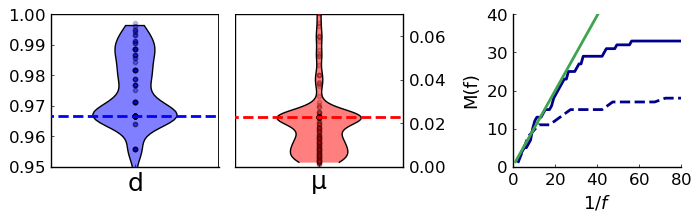

In [172]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.95, 1.0)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black)
vline!(p[1], [xlim[2]], c=:black, lw=2)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.2, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 0.07)
yticks = range(ylim..., step=0.02)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black)
vline!(p[2], [xlim[1]], c=:black)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.2, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
M!(p[end], TumorGrowth.mutation_freqs(sanger).frequency, nbins=50, lab="sanger", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="")

# mean

0.9665448025598967
0.02277772316160796


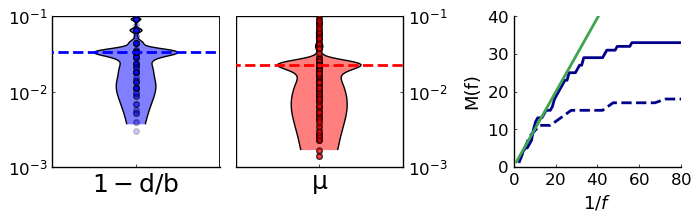

In [169]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"1-d/b"]), yscale=:log10)
hline!(p[1], [ylim[2]], c=:black)
vline!(p[1], [xlim[2]], c=:black, lw=2)
violin!(p[1], [1], 1 .- ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], 1 .- ds, c=:blue, alpha=0.2, ms = 4)
hline!(p[1], [median(1 .- ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"\mu"]), ymirror=true, yscale=:log10)
hline!(p[2], [ylim[2]], c=:black)
vline!(p[2], [xlim[1]], c=:black)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.95), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 4)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
M!(p[end], TumorGrowth.mutation_freqs(sanger).frequency, nbins=50, lab="sanger", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="")

# mean

0.9665448025598967
0.01788602210611112


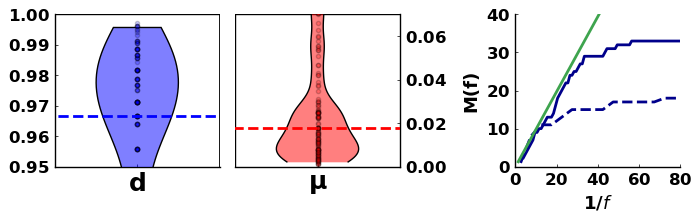

In [69]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.95, 1.0)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black)
vline!(p[1], [xlim[2]], c=:black, lw=2)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.2, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 0.07)
yticks = range(ylim..., step=0.02)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black)
vline!(p[2], [xlim[1]], c=:black)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.2, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
M!(p[end], TumorGrowth.mutation_freqs(sanger).frequency, nbins=50, lab="sanger", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="")

# mean

0.9665448025598967
0.01788602210611112


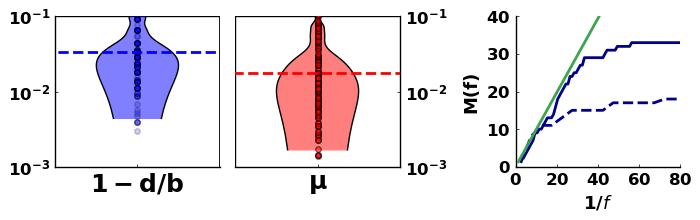

In [70]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"1-d/b"]), yscale=:log10)
hline!(p[1], [ylim[2]], c=:black)
vline!(p[1], [xlim[2]], c=:black, lw=2)
violin!(p[1], [1], 1 .- ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], 1 .- ds, c=:blue, alpha=0.2, ms = 4)
hline!(p[1], [median(1 .- ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"\mu"]), ymirror=true, yscale=:log10)
hline!(p[2], [ylim[2]], c=:black)
vline!(p[2], [xlim[1]], c=:black)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.95), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 4)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
M!(p[end], TumorGrowth.mutation_freqs(sanger).frequency, nbins=50, lab="sanger", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="")

# mean

> min_samples = 10

0.9632951538447542
0.02435675437504325


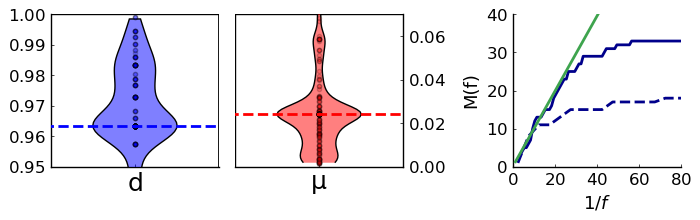

In [175]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.95, 1.0)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black)
vline!(p[1], [xlim[2]], c=:black, lw=2)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.2, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 0.07)
yticks = range(ylim..., step=0.02)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black)
vline!(p[2], [xlim[1]], c=:black)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.2, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
M!(p[end], TumorGrowth.mutation_freqs(sanger).frequency, nbins=50, lab="sanger", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="")

# mean

0.9632951538447542
0.02435675437504325


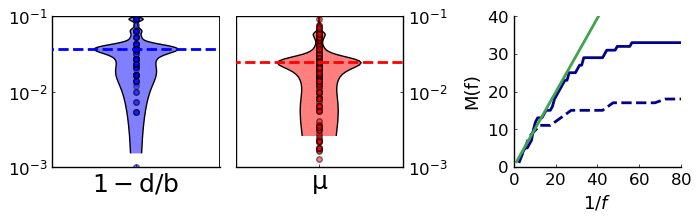

In [176]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"1-d/b"]), yscale=:log10)
hline!(p[1], [ylim[2]], c=:black)
vline!(p[1], [xlim[2]], c=:black, lw=2)
violin!(p[1], [1], 1 .- ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], 1 .- ds, c=:blue, alpha=0.2, ms = 4)
hline!(p[1], [median(1 .- ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"\mu"]), ymirror=true, yscale=:log10)
hline!(p[2], [ylim[2]], c=:black)
vline!(p[2], [xlim[1]], c=:black)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.95), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 4)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
M!(p[end], TumorGrowth.mutation_freqs(sanger).frequency, nbins=50, lab="sanger", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="")

# mean

0.9632951538447542
0.023632858341619906


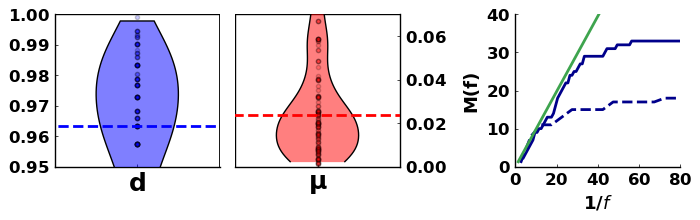

In [73]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.95, 1.0)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black)
vline!(p[1], [xlim[2]], c=:black, lw=2)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.2, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 0.07)
yticks = range(ylim..., step=0.02)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black)
vline!(p[2], [xlim[1]], c=:black)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.2, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
M!(p[end], TumorGrowth.mutation_freqs(sanger).frequency, nbins=50, lab="sanger", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="")

# mean

0.9632951538447542
0.023632858341619906


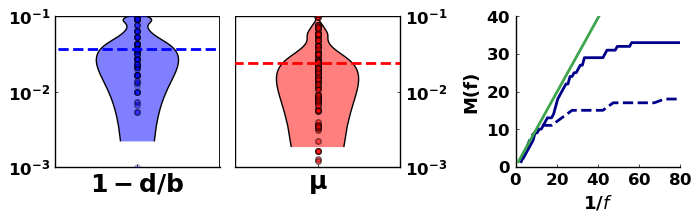

In [74]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"1-d/b"]), yscale=:log10)
hline!(p[1], [ylim[2]], c=:black)
vline!(p[1], [xlim[2]], c=:black, lw=2)
violin!(p[1], [1], 1 .- ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], 1 .- ds, c=:blue, alpha=0.2, ms = 4)
hline!(p[1], [median(1 .- ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.001, 0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"\mu"]), ymirror=true, yscale=:log10)
hline!(p[2], [ylim[2]], c=:black)
vline!(p[2], [xlim[1]], c=:black)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.95), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 4)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
M!(p[end], TumorGrowth.mutation_freqs(sanger).frequency, nbins=50, lab="sanger", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="")

# mean

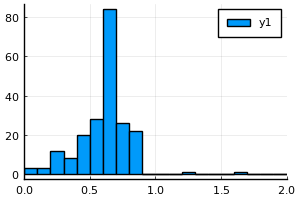

In [179]:
histogram( mus ./ (1 .- ds), size=(300,200), xlim=(0,2) )

In [40]:
L = 1270015
muL = 0.015
mu = muL / L

1.1810884123415865e-8

## *save*

In [39]:
# name = "lichee_sottoriva"
name = "coinc_sottoriva_params_1-d"
savefig("Turnover\\turnover_plots\\inference\\"* name * ".pdf")
savefig("Turnover\\turnover_plots\\inference\\"* name * ".png")

## Sanger: *sanger 'frequencies'*

> ***set thresholds***

In [9]:
n = nrow(sanger)
min_samples = 3
N = n^(3/2) * 2/(π^(1/2)*3^(1/4)) / min_samples

1375.0572522077166

In [10]:
tumor = deepcopy(sanger_lichee)
turnover_params = (
    f_min = 1 / floor(nrow(sanger)/min_samples),
    N = N,
    )
freqs = TumorGrowth.mutation_freqs(sanger) |> df -> Dict(df.mutation .=> df.frequency)
;

### single call

In [11]:
orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > turnover_params[:f_min],
            tumor.mutations) ) )
    
# get d
W_l = orphaned_red_treeless(orphaned_tumor) |> 
    df -> sum( df.isorphaned ) / sum( df.isgreen )

# d_solve = min(1., 2*log(turnover_params[:Nthresh_orph])*W_l)
d_solve = fzero(x -> min(1., Turnover.W_orphaned( x; 
            N= turnover_params[:N] * (1-x))) - W_l,
            0.01, 0.999) 

0.9927975988776796

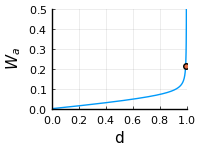

In [12]:
plot(0:0.001:1., x -> Turnover.W_orphaned( x; N= turnover_params[:N]*(1-x) ), xlim=(0,1), ylim=(0,0.5), size=(200,150), lab=:none)
scatter!([d_solve], [W_l], lab=:none, xlab=:d, ylab=L"W_a")

In [13]:
estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > turnover_params[:f_min] for m in muts), tumor.mutations) )

# get mu
W_c = estranged_treeless(estranged_tumor) |> 
        df -> sum( df.isestranged ) / sum( df.isgreen )

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu,
            T=log(turnover_params[:N]*(1-d_solve)) / (1-d_solve)))- W_c, 0.0001, 0.9999)

0.001509339701125478

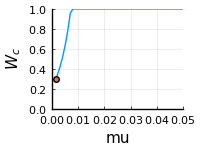

In [14]:
plot(0:0.001:0.05, mu -> min(1., W_estranged(d_solve; b=1., μ=mu, 
            T=log(turnover_params[:N]*(1-d_solve))/(1-d_solve))),
    xlim=(0,0.05), ylim=(0,1.0), size=(200,150), lab=:none)
scatter!([mu_solve], [W_c], lab=:none, xlab=:mu, ylab=L"W_c")

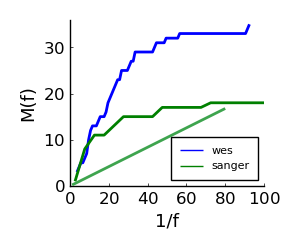

In [15]:
wes_freqs = SeqDataFormatting.mfreqs(wes).frequency

p = plot(layout=(1,1), size=(300,250), grid=false, xlab=L"1/f", ylab=L"M(f)", xlim=(0, 100),
    labelfontsize=13, tickfontsize=12, margin=5Plots.mm, legend=:bottomright)
M!(p[1], wes_freqs, nbins=50, lab="wes", lw=2., ylim=(0,36), c = :blue)
M!(p[1], collect( values(freqs) ), nbins=50, lab="sanger", lw=2., ylim=(0,36), c = :green)
plot!(p[1], 1:80, x-> x*mu_solve/(1-d_solve), lw=2., lab="")

### vary samplesize

0.9927975988776796


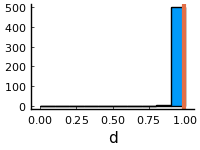

In [16]:
ds = map( 0.5:0.1:1. ) do L
    map( 1:100 ) do _
        orphaned_tumor = DataFrame( mutations = unique( 
                filter.(m-> freqs[m] > turnover_params[:f_min], tumor.mutations) ) )
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum( df.isorphaned ) / sum( df.isgreen )

        d_solve = try
            fzero(x -> min(1., Turnover.W_orphaned( x; 
                        N= turnover_params[:N]*(1-x))) - W_l, 0.001, 0.999)
        catch e
            e isa ArgumentError && NaN
        end
    end
end
filter!.(!isnan, ds)
println(median(vcat(ds...)))
histogram(vcat(ds...), bins=0.:0.1:1., size=(200,150), lab="")
vline!([median(vcat(ds...))], lab="", lw=3., grid=false, xlab=:d)

In [17]:
d_solve=0.993

0.993

In [18]:
estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > turnover_params[:f_min] for m in muts), tumor.mutations) )

# get mu
W_c = estranged_treeless(estranged_tumor) |> 
        df -> sum( df.isestranged ) / sum( df.isgreen )

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, 
            T=log(turnover_params[:N]*(1-d_solve))/(1-d_solve)))- W_c, 0.001, 0.999)

0.00142658347306374

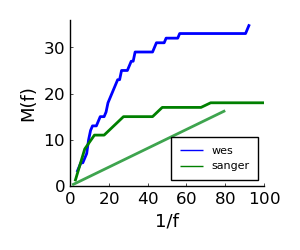

In [19]:
wes_freqs = SeqDataFormatting.mfreqs(wes).frequency

p = plot(layout=(1,1), size=(300,250), grid=false, xlab=L"1/f", ylab=L"M(f)", xlim=(0, 100),
    labelfontsize=13, tickfontsize=12, margin=5Plots.mm, legend=:bottomright)
M!(p[1], wes_freqs, nbins=50, lab="wes", lw=2., ylim=(0,36), c = :blue)
M!(p[1], collect( values(freqs) ), nbins=50, lab="sanger", lw=2., ylim=(0,36), c = :green)
plot!(p[1], 1:80, x-> x*mu_solve/(1-d_solve), lw=2., lab="")

In [155]:
ds = map( 0.5:0.1:1. ) do L
   map( 1:10 ) do _
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > turnover_params[:f_min], tumor.mutations) ) )
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum( df.isorphaned ) / sum( df.isgreen )

        d_solve = try
            fzero(x -> min(1., Turnover.W_orphaned( x; N= turnover_params[:N] * (1-x) )) - W_l, 0.001, 0.999)
        catch e
            e isa ArgumentError && 1.
        end
    end
end;

mean fit : 0.0033583341802004845
averaged fits : 0.0032308376140633664 ± 7.544154399087276e-5


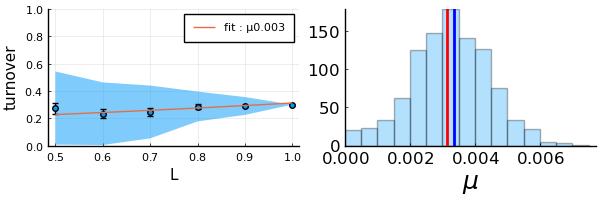

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [156]:
let d = d_solve
    Ls = 0.5:0.1:1.
    reps = 50
    estranged_tumors = map( Ls ) do L
        [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
    end

    estranged_turnover = map(estranged_tumors) do set
            filter!(!isnan, map(set) do tumor
                res = estranged_treeless(tumor)
                sum( res.isestranged ) / sum( res.isgreen )
                end ) 
        end

    Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])
    
    global Nthresh
    function model(Ls, p)
        local mu = p[1]
        (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
        map( Ls ) do L
            min(1., W_estranged(d; b=1., μ=mu*L, 
                    T=log(turnover_params[:N]*(1-d))/(1-d)))
        end
    end
    fit = curve_fit(model, Ls, mean.(t), [(1-d)/2])
    mu_fit = fit.param[1]

    p1 = scatter( Ls, mean.(t), ribbon=std.(t), yerror = std.(t)./sqrt.(length.(t)), lab="", 
        xlab=:L, ylab=:turnover, legend=:topright, ylim=(0,1))
    plot!(Ls, model(Ls, fit.param), lab="fit : μ$(round(mu_fit,digits=3))" )

    tvecs = [ rand.(t) for _=1:1000 ]
    fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
    mu_fits = getindex.(getfield.(fits, :param),1)
    p2 = histogram( mu_fits, lab="", alpha=0.3, xlim=(0,:auto), nbins=30, size=(400,250), ylim=(0,:auto))
    vline!([mu_fit], lab="", lw=2., c=:blue, tickfontsize=12, labelfontsize=18, xlab=L"\mu", grid=false )
    vline!([mu_solve], lab="", lw=2., c=:red)

    println("mean fit : ", mu_fit)
    println("averaged fits : ", mean(mu_fits), " ± ", 1.96*std(mu_fits)/sqrt(length(mu_fits)))
    plot(p1,p2, size=(600,200))

#     savefig("Turnover/turnover_plots/experimental_data/sanger_wesfreqs_mu.pdf")
end

In [20]:
ds = map( 0.2:0.1:1. ) do L
    map( 1:100 ) do _
        orphaned_tumor = DataFrame( mutations = unique( 
                filter.(m-> freqs[m] > turnover_params[:f_min], tumor.mutations) ) )
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)

        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum( df.isorphaned ) / sum( df.isgreen )

        d_solve = try
            fzero(x -> min(1., Turnover.W_orphaned( x;
                        N= turnover_params[:N]*(1-x))) - W_l, 0.001, 0.999)
        catch e
            e isa ArgumentError && NaN
        end
    end
end
filter!.(!isnan, ds)
ds = vcat(ds...)
d_solve = median(ds)

estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > turnover_params[:f_min] for m in muts), tumor.mutations) )
# get mu
W_c = estranged_treeless(estranged_tumor) |> df -> sum( df.isestranged ) / sum( df.isgreen ) 

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:N])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu,
            T=log(turnover_params[:N]*(1-d_solve))/(1-d_solve)))- W_c, 0.001, 0.999)

Ls = 0.4:0.1:1.
reps = 200
estranged_tumors = map( Ls ) do L
    [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
end

estranged_turnover = map(estranged_tumors) do set
        filter!(!isnan, set .|> estranged_treeless .|> df -> sum( df.isestranged ) / sum( df.isgreen ))
    end

Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

function model(Ls, p)
    local mu = p[1]
    (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
    map( Ls ) do L
        min(1., W_estranged(d_solve; b=1., μ=mu*L,
                T=log(turnover_params[:N]*(1-d_solve))/(1-d_solve)))
    end
end
# fitres = curve_fit(model, Ls, mean.(t), [(1-d_solve)/2])
fitres = curve_fit(model, vcat( [ fill(Ls[i], length(t_)) for (i,t_) in enumerate(t)]... ), 
    vcat(t...), [(1-d_solve)/2])
mu_fit = fitres.param[1]

tvecs = [ rand.(t) for _=1:10000 ]
fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
mu_fits = getindex.(getfield.(fits, :param),1);

0.9951707029989295
0.0009467966461068212


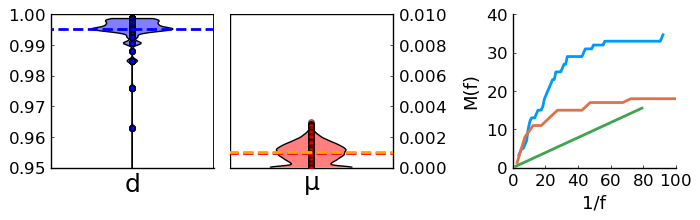

In [166]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

plot!(p[1], legend=:none, xlim=(0.2,1.8), xtickfontsize=18, ylim=(0.95,1.), xticks=([1],[L"d"]))#, xaxis=:off)
hline!(p[1], [1], c=:black)
vline!(p[1], [1.8], c=:black, lw=2)
violin!(p[1], [1], ds, c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5)
hline!(p[1], [d_solve], c=:blue, lw=2., style=:dash)
println(d_solve)

plot!(p[2], legend=:none, xlim=(0.2,1.8), xtickfontsize=18, ylim=(0,0.01), xticks=([1],[L"\mu"]), ymirror=true)#, xaxis=:off)
hline!(p[2], [0.01], c=:black)
vline!(p[2], [0.2], c=:black)
violin!(p[2], [1], mu_fits, c=:red, fillalpha=0.5)
scatter!(p[2], [1], mu_fits, c=:red, alpha=0.5)
hline!(p[2], [median(mu_fits)], c=:red, lw=2., style=:dash)
println(median(mu_fits))
hline!(p[2], [mu_solve], c=:orange, lw=2., style=:dash)

res = 1/100
plot!(p[3], tickfontsize=12, labelfontsize=13)
M!(p[3], wes_freqs, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40))
M!(p[3], collect(values(freqs)), nbins=50, lab="sanger",
    lw=2.)
plot!(p[3], 1:80, x-> x*median(mu_fits)/(1-d_solve), lw=2., lab="")

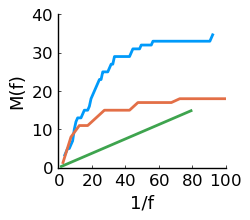

In [26]:
p = plot(layout=(1,1), size=(250,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

# plot!(p[1], legend=:none, xlim=(0.2,1.8), xtickfontsize=18, ylim=(0.95,1.), xticks=([1],[L"d"]))#, xaxis=:off)
# hline!(p[1], [1], c=:black)
# vline!(p[1], [1.8], c=:black, lw=2)
# violin!(p[1], [1], ds, c=:blue, fillalpha=0.5)
# scatter!(p[1], [1], ds, c=:blue, alpha=0.5)
# hline!(p[1], [d_solve], c=:blue, lw=2., style=:dash)
# println(d_solve)

# plot!(p[2], legend=:none, xlim=(0.2,1.8), xtickfontsize=18, ylim=(0,0.01), xticks=([1],[L"\mu"]), ymirror=true)#, xaxis=:off)
# hline!(p[2], [0.01], c=:black)
# vline!(p[2], [0.2], c=:black)
# violin!(p[2], [1], mu_fits, c=:red, fillalpha=0.5)
# scatter!(p[2], [1], mu_fits, c=:red, alpha=0.5)
# hline!(p[2], [median(mu_fits)], c=:red, lw=2., style=:dash)
# println(median(mu_fits))
# hline!(p[2], [mu_solve], c=:orange, lw=2., style=:dash)

res = 1/100
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], wes_freqs, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40))
M!(p[end], collect(values(freqs)), nbins=50, lab="sanger",
    lw=2.)
plot!(p[end], 1:80, x-> x*median(mu_fits)/(1-d_solve), lw=2., lab="")

In [27]:
name = "lichee_sangerfreqs_sottoriva"
savefig("Turnover\\turnover_plots\\inference\\"* name * ".pdf")
savefig("Turnover\\turnover_plots\\inference\\"* name * ".png")

## Sanger: *wes frequencies*

### experimental

In [108]:
n = nrow(sanger)
min_samples = 10
N = n^(3/2) * 2/(π^(1/2)*3^(1/4)) / min_samples

412.517175662315

In [110]:
turnover_params = ( f_min = 1/20, Nthresh_orph = 95, Nthresh_estr = 95, )
turnover_params = ( f_min = min_samples, Nthresh_orph = N, Nthresh_estr = N, )

freqs = SeqDataFormatting.mfreqs(wes) |> df -> Dict(df.mutation .=> df.frequency)
samplecounts = TumorGrowth.mutation_freqs(sanger) |> df -> Dict(df.mutation .=> df.reads)

tumor = deepcopy(sanger_lichee)
# tumor = deepcopy(sanger_coinc)
# tumor = deepcopy(sanger);

#### *single call*

In [104]:
orphaned_tumor = DataFrame( mutations = unique( filter.(m-> samplecounts[m] >= turnover_params[:f_min],
            tumor.mutations) ) )
    
# get d
W_l = orphaned_red_treeless(orphaned_tumor) |> 
    df -> sum( df.isorphaned ) / sum( df.isgreen )

# d_solve = min(1., 2*log(turnover_params[:Nthresh_orph])*W_l)
d_solve = fzero(x -> min(1., Turnover.W_orphaned( x; 
            N= turnover_params[:Nthresh_orph] * (1-x))) - W_l,
            0.001, 0.999) 

0.9920243845307387

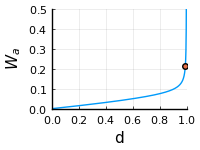

In [75]:
plot(0:0.001:1., x -> Turnover.W_orphaned( x; N= turnover_params[:Nthresh_orph]*(1-x) ), xlim=(0,1), ylim=(0,0.5), size=(200,150), lab=:none)
scatter!([d_solve], [W_l], lab=:none, xlab=:d, ylab=L"W_a")

In [76]:
estranged_tumor = DataFrame(mutations = filter( muts -> all(  samplecounts[m] > turnover_params[:f_min] for m in muts), tumor.mutations) )

# get mu
W_c = estranged_treeless(estranged_tumor) |> 
        df -> sum( df.isestranged ) / sum( df.isgreen )

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu,
            T=log(turnover_params[:Nthresh_estr] *(1-d_solve)) / (1-d_solve)))- W_c, 0.001, 0.999)

0.002640431196355597

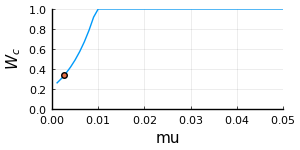

In [78]:
plot(0:0.001:1., mu -> min(1., W_estranged(d_solve; b=1., μ=mu, 
            T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve))),
    xlim=(0,0.05), ylim=(0,1.0), size=(300,150), lab=:none)
scatter!([mu_solve], [W_c], lab=:none, xlab=:mu, ylab=L"W_c")

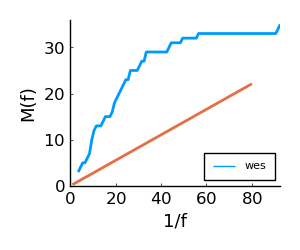

In [79]:
wes_freqs = SeqDataFormatting.mfreqs(wes).frequency

p = plot(layout=(1,1), size=(300,250), grid=false, xlab=L"1/f", ylab=L"M(f)", xlim=(0, :auto),
    labelfontsize=13, tickfontsize=12, margin=5Plots.mm, legend=:bottomright)
M!(p[1], wes_freqs, nbins=50, lab="wes", lw=2., ylim=(0,36))
plot!(p[1], 1:80, x-> x*mu_solve/(1-d_solve), lw=2., lab="")

#### *vary samplesize*

0.9932125831160558


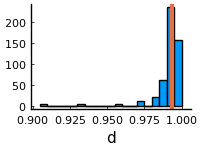

In [80]:
ds = map( 0.5:0.1:1. ) do L
    map( 1:100 ) do _
        orphaned_tumor = DataFrame( mutations = unique( 
                filter.(m-> samplecounts[m] > turnover_params[:f_min], tumor.mutations) ) )
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum( df.isorphaned ) / sum( df.isgreen )

        d_solve = try
            fzero(x -> min(1., Turnover.W_orphaned( x; 
                        N= turnover_params[:Nthresh_orph]*(1-x))) - W_l, 0.001, 0.999)
        catch e
            e isa ArgumentError && NaN
        end
    end
end
filter!.(!isnan, ds)
println(median(vcat(ds...)))
histogram(vcat(ds...), nbins=40, size=(200,150), lab="")
vline!([median(vcat(ds...))], lab="", lw=3., grid=false, xlab=:d)

In [82]:
d_solve=0.993

0.993

In [175]:
estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > turnover_params[:f_min] for m in muts), tumor.mutations) )

# get mu
W_c = estranged_treeless(estranged_tumor) |> 
        df -> sum( df.isestranged ) / sum( df.isgreen )

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, 
            T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, 0.01, 0.99)

0.021961748770043036

In [84]:
estranged_tumor = DataFrame(mutations = filter( muts -> all(  samplecounts[m] > turnover_params[:f_min] for m in muts), tumor.mutations) )

# get mu
W_c = estranged_treeless(estranged_tumor) |> 
        df -> sum( df.isestranged ) / sum( df.isgreen )

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, 
            T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, 0.001, 0.999)

0.0014685452821788791

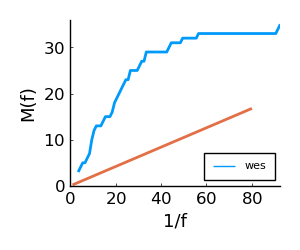

In [85]:
wes_freqs = SeqDataFormatting.mfreqs(wes).frequency

p = plot(layout=(1,1), size=(300,250), grid=false, xlab=L"1/f", ylab=L"M(f)", xlim=(0, :auto),
    labelfontsize=13, tickfontsize=12, margin=5Plots.mm, legend=:bottomright)
M!(p[1], wes_freqs, nbins=50, lab="wes", lw=2., ylim=(0,36))
plot!(p[1], 1:80, x-> x*mu_solve/(1-d_solve), lw=2., lab="")

mean fit : 0.002836068492557036
averaged fits : 0.0027481255369322557 ± 5.930765361291411e-5


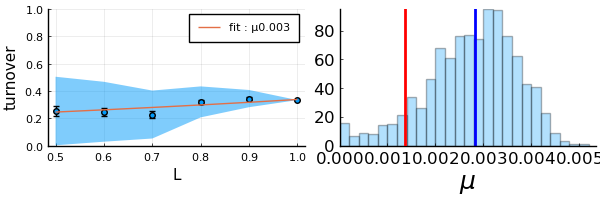

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [105]:
let d = d_solve
    Ls = 0.5:0.1:1.
    reps = 50
    estranged_tumors = map( Ls ) do L
        [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
    end

    estranged_turnover = map(estranged_tumors) do set
            filter!(!isnan, map(set) do tumor
                res = estranged_treeless(tumor)
                sum( res.isestranged ) / sum( res.isgreen )
                end ) 
        end

    Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])
    
    global Nthresh
    function model(Ls, p)
        local mu = p[1]
        (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
        map( Ls ) do L
            min(1., W_estranged(d; b=1., μ=mu*L, 
                    T=log(turnover_params[:Nthresh_estr]*(1-d))/(1-d)))
        end
    end
    fit = curve_fit(model, Ls, mean.(t), [(1-d)/2])
    mu_fit = fit.param[1]

    p1 = scatter( Ls, mean.(t), ribbon=std.(t), yerror = std.(t)./sqrt.(length.(t)), lab="", 
        xlab=:L, ylab=:turnover, legend=:topright, ylim=(0,1))
    plot!(Ls, model(Ls, fit.param), lab="fit : μ$(round(mu_fit,digits=3))" )

    tvecs = [ rand.(t) for _=1:1000 ]
    fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
    mu_fits = getindex.(getfield.(fits, :param),1)
    p2 = histogram( mu_fits, lab="", alpha=0.3, xlim=(0,:auto), nbins=30, size=(400,250), ylim=(0,:auto))
    vline!([mu_fit], lab="", lw=2., c=:blue, tickfontsize=12, labelfontsize=18, xlab=L"\mu", grid=false )
    vline!([mu_solve], lab="", lw=2., c=:red)

    println("mean fit : ", mu_fit)
    println("averaged fits : ", mean(mu_fits), " ± ", 1.96*std(mu_fits)/sqrt(length(mu_fits)))
    plot(p1,p2, size=(600,200))

#     savefig("Turnover/turnover_plots/experimental_data/sanger_wesfreqs_mu.pdf")
end

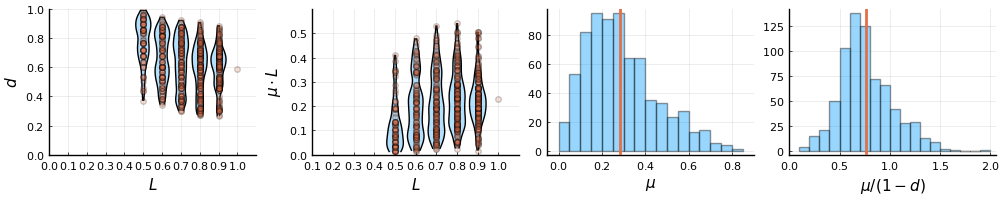

In [165]:
params = (
    f_min = 1/20,
    Nthresh_orph =90,
    Nthresh_estr = 90,
    )

freqs = SeqDataFormatting.mfreqs(wes_init) |> df -> Dict( df.mutation .=> df.frequency)
mutations = union(wes_init.mutations...)
results = Vector()
Ls = Float64[]
for L = 0.5:0.1:1.
    for _=1:200
        tumor = deepcopy(select(sanger, :mutations))
        
        selection = sample(mutations, floor(Int, length(mutations)*L), replace =false)
        filter!.(m -> m in selection, tumor.mutations)
        
        # freqs = TumorGrowth.mutation_freqs(tumor) |> df -> Dict( df.mutation .=> df.frequency)
        
        # filter!.(m-> 1.1 > freqs[m] > params[:f_min], tumor.mutations)

        htypes = unique(tumor.mutations)
        orphaned_tumor = DataFrame( mutations = unique( 
                filter.(m-> freqs[m] > params[:f_min], htypes) ) )
        estranged_tumor = DataFrame(mutations = filter( 
                muts -> all(  freqs[m] > params[:f_min] for m in muts), htypes) )

        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |>
            df -> sum(df.isorphaned)/sum(df.isgreen) 
        
        # d_solve = min(1., 2*log(params[:Nthresh_orph])*W_l)
        try
            d_solve = fzero(x -> min(1., Turnover.W_orphaned( x; 
                N= params[:Nthresh_orph] * (1-x))) - W_l,
                0.01, 0.99)
        catch e
            d_solve = 1
        end
        
        (isnan(d_solve) || isone(d_solve) || iszero(d_solve)) && continue
        
        # get mu
        W_c = estranged_treeless(estranged_tumor) |> 
            df -> sum(df.isestranged)/sum(df.isgreen) 
        try
#             mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, 
                        T=log(params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, 0.01, 0.99)
            mu_solve ≈ 0.99 && continue
            
            push!(results, (d_solve, mu_solve))
            push!(Ls, L)
            L==1. && break
            catch e
        end
        
    end
end
p = plot(layout=(1,4), legend=:none, size=(1000,200))
scalex = 10

violin!(p[1], scalex*Ls, getindex.(results,1), fillalpha=0.3, xticks = ([0:scalex;], [(0:scalex) ./ scalex;]))
scatter!(p[1], scalex*Ls, getindex.(results, 1), alpha=0.2, xlim=(0,scalex*1.1), ylim=(0,1), xlab = L"L", ylab=L"d")
# hline!(p[1], [mean(getindex.(results, 1))], lw=2.)

violin!(p[2], scalex*Ls, getindex.(results,2), fillalpha=0.3, xticks = ([1:scalex;], [(1:scalex) ./ scalex;]))
scatter!(p[2], scalex*Ls, getindex.(results, 2), alpha=0.2, xlim=(4,scalex+1), ylim=(0,0.6), xlab = L"L", ylab=L"\mu\cdot L")
# plot!(p[2], [0,scalex], [0,last(results)[2]], lw=2.)

histogram!(p[3], getindex.(results, 2)./Ls, nbins=30, alpha=0.4, xlab = L"\mu")
vline!(p[3], [mean(getindex.(results, 2)./Ls)], lw=2. )

slope = filter(x -> x< 4, getindex.(results, 2)./Ls ./ (1 .- getindex.(results, 1)))

histogram!(p[4], slope, xlim=(0,:auto), nbins=30, alpha=0.4 , xlab = L"\mu/(1-d)")
vline!(p[4], [mean(slope)], lw=2. )

## Wes data

In [49]:
wes_init = TumorGrowth.data_import("experimental_data/LingProcessed/experimental_data_WES.csv", delim="\t");

In [187]:
turnover_params = ( f_min=1/20, Nthresh_orph = 95, Nthresh_estr = 95, )
filter_params =  (cutoff_low = 1/100, sample_cutoff_low = 1/3, )
# mutnumb = 100

wes = deepcopy(wes_init)
SeqDataFormatting.filter_by_freq!(wes; filter_params...)
# SeqDataFormatting.subsample!(wes; nmuts = mutnumb)
freqs = SeqDataFormatting.mfreqs(wes) |> df -> Dict( df.mutation .=> df.frequency);

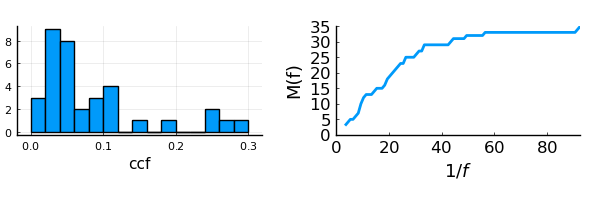

In [188]:
freqs = SeqDataFormatting.mfreqs(wes_init).frequency

p = plot(layout=(1,2), size=(600,200))
histogram!(p[1], filter( f-> 0.8 > f, freqs), nbins=20, lab="", xlab=:ccf)
M!(p[2], filter( f-> 0.8 > f > res, freqs), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
    labelfontsize=13, tickfontsize=12, grid=false, margin=5Plots.mm, lw=2.,
    xlim=(0, :auto), ylim=(0,:auto))

In [189]:
htypes = unique(wes.mutations)
orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > turnover_params[:f_min], htypes) ) )
estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > turnover_params[:f_min] for m in muts), htypes) )

# get d
W_l = orphaned_red_treeless(orphaned_tumor) |>
        df -> sum(df.isorphaned)/sum(df.isgreen)

d_solve = fzero(x -> min(1., Turnover.W_orphaned( x; N= turnover_params[:Nthresh_orph] * (1-x))) - W_l,
    0.01, 0.99) 

0.8762160510544

0.8762160510544


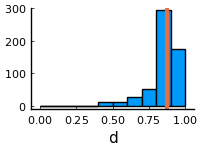

In [190]:
ds = map( 0.5:0.1:1. ) do L
    map( 1:100 ) do _
        orphaned_tumor = DataFrame( mutations = unique( 
                filter.(m-> freqs[m] > turnover_params[:f_min], wes.mutations) ) )
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum( df.isorphaned ) / sum( df.isgreen )

        d_solve = try
            fzero(x -> min(1., Turnover.W_orphaned( x; 
                        N= turnover_params[:Nthresh_orph]*(1-x))) - W_l, 0.01, 0.99)
        catch e
            e isa ArgumentError && NaN
        end
    end
end
filter!.(!isnan, ds)
println(median(vcat(ds...)))
histogram(vcat(ds...), bins=0.:0.1:1., size=(200,150), lab="")
vline!([median(vcat(ds...))], lab="", lw=3., grid=false, xlab=:d)

In [191]:
d_solve = 0.88

0.88

In [192]:
# get mu
W_c = estranged_treeless(estranged_tumor) |> df -> sum(df.isestranged)/sum(df.isgreen)

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, 
            T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, 0.01, 0.99)

0.10394503269211729

In [195]:
# get mu

Ls = 0.5:0.1:1.
reps = 10
estranged_tumors = map( Ls ) do L
    [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
end

estranged_turnover = map(estranged_tumors) do set
        filter!(!isnan, map(set) do tumor
            res = estranged_treeless(tumor)
            sum(res.isestranged)/sum(res.isgreen)
        end )
    end

Ls, estranged_turnover = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

function model(Ls, p)
    local mu = p[1]
    (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
    map( Ls ) do L
        min(1., W_estranged(d_solve; b=1, μ=mu*L,
                T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))
    end
end

fitres = curve_fit(model, Ls, mean.(estranged_turnover), [(1-d_solve)/2])
mu_fit = fitres.param[1]


0.09906900719637682

mean fit : 0.09906900725102301
averaged fits : 0.09854510123892661 ± 0.0007669567181210474


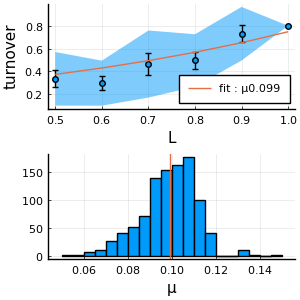

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [196]:
let d = d_solve
    t = estranged_turnover
    global Nthresh
    function model(Ls, p)
        local mu = p[1]
        (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
        map( Ls ) do L
            min(1., W_estranged(d; b=1., μ=mu*L, T=log(turnover_params[:Nthresh_estr]*(1-d))/(1-d)))
        end
    end
    fit = curve_fit(model, Ls, mean.(t), [0.001])
    mu_fit = fit.param[1]

    p1 = scatter(Ls, mean.(t), ribbon=std.(t), 
        yerror = std.(t)./sqrt.(length.(t)), lab="", xlab=:L, ylab=:turnover, legend=:bottomright)
    plot!(Ls, model(Ls, fit.param), lab="fit : μ$(round(mu_fit,digits=3))" )

    tvecs = [ rand.(t) for _=1:1000 ]
    fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
    mu_fits = getindex.(getfield.(fits, :param),1)
    p2 = histogram(mu_fits, xlab="μ", lab="")
    vline!([mu_fit], lab="")

    println("mean fit : ", mu_fit)
    println("averaged fits : ", mean(mu_fits), " ± ", 1.96*std(mu_fits)/sqrt(length(mu_fits)))
    plot(p1, p2, layout=(2,1), size=(300,300))
end

In [197]:
mu_solve = 0.1

0.1

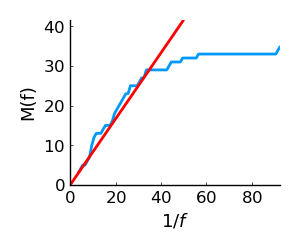

In [198]:
M(filter( f-> 0.8 > f, collect(values(wes_freqs))), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
    labelfontsize=13, tickfontsize=12, grid=false, margin=5Plots.mm, lw=2., xlim=(0, :auto), ylim=(0,:auto), size=(300,250))
plot!(0:50, x-> x*mu_solve/(1-d_solve), lab="", c=:red, lw=2.)

In [199]:
ds = map( 0.5:0.1:1. ) do L
    map( 1:100 ) do _
        orphaned_tumor = DataFrame( mutations = unique( 
                filter.(m-> freqs[m] > turnover_params[:f_min], wes.mutations) ) )
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)

        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum( df.isorphaned ) / sum( df.isgreen )

        d_solve = try
            fzero(x -> min(1., Turnover.W_orphaned( x;
                        N= turnover_params[:Nthresh_orph]*(1-x))) - W_l, 0.01, 0.99)
        catch e
            e isa ArgumentError && NaN
        end
    end
end
filter!.(!isnan, ds)
ds = vcat(ds...)
d_solve = median(ds)

estranged_tumor = DataFrame(mutations = filter( muts -> all(  
            freqs[m] > turnover_params[:f_min] for m in muts), wes.mutations) )
# get mu
W_c = estranged_treeless(estranged_tumor) |> df -> sum( df.isestranged ) / sum( df.isgreen ) #|> mes2theory_estranged

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu,
            T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, 0.01, 0.99)

Ls = 0.4:0.1:1.
reps = 50
estranged_tumors = map( Ls ) do L
    [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
end

estranged_turnover = map(estranged_tumors) do set
        filter!(!isnan, set .|> estranged_treeless .|> df -> sum( df.isestranged ) / sum( df.isgreen ))
    end

Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

function model(Ls, p)
    local mu = p[1]
    (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
    map( Ls ) do L
        min(1., W_estranged(d_solve; b=1., μ=mu*L,
                T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))
    end
end
# fitres = curve_fit(model, Ls, mean.(t), [(1-d_solve)/2])
fitres = curve_fit(model, vcat( [ fill(Ls[i], length(t_)) for (i,t_) in enumerate(t)]... ), 
    vcat(t...), [(1-d_solve)/2])
mu_fit = fitres.param[1]

tvecs = [ rand.(t) for _=1:1000 ]
fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
mu_fits = getindex.(getfield.(fits, :param),1);

0.8762160510544
0.10868847232795248 0.10736717377533075


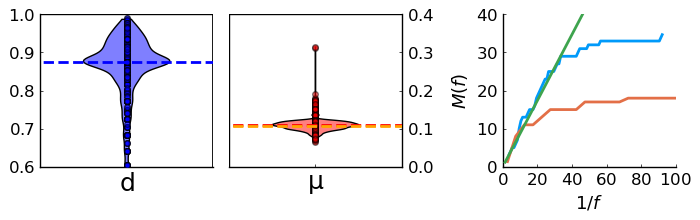

In [208]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

plot!(p[1], legend=:none, xlim=(0.2,1.8), xtickfontsize=18, ylim=(0.6,1.), xticks=([1],[L"d"]))#, xaxis=:off)
hline!(p[1], [1], c=:black)
vline!(p[1], [1.8], c=:black, lw=2)
violin!(p[1], [1], ds, c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5)
hline!(p[1], [d_solve], c=:blue, lw=2., style=:dash)
println(d_solve)

plot!(p[2], legend=:none, xlim=(0.2,1.8), xtickfontsize=18, ylim=(0,0.4), xticks=([1],[L"\mu"]), ymirror=true)#, xaxis=:off)
hline!(p[2], [0.4], c=:black)
vline!(p[2], [0.2], c=:black)
violin!(p[2], [1], mu_fits, c=:red, fillalpha=0.5)
scatter!(p[2], [1], mu_fits, c=:red, alpha=0.5)
hline!(p[2], [median(mu_fits)], c=:red, lw=2., style=:dash)
println(median(mu_fits), " ", mu_solve)
hline!(p[2], [mu_solve], c=:orange, lw=2., style=:dash)

res = 1/100
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], collect(values(wes_freqs)), nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40))
M!(p[end], collect(values(sanger_freqs)), nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40))
plot!(p[end], 1:80, x-> x*mu_solve/(1-d_solve), lw=2., lab="")

In [207]:
name = "wes_wesfreqs_sottoriva"
savefig("Turnover\\turnover_plots\\inference\\"* name * ".pdf")
savefig("Turnover\\turnover_plots\\inference\\"* name * ".png")

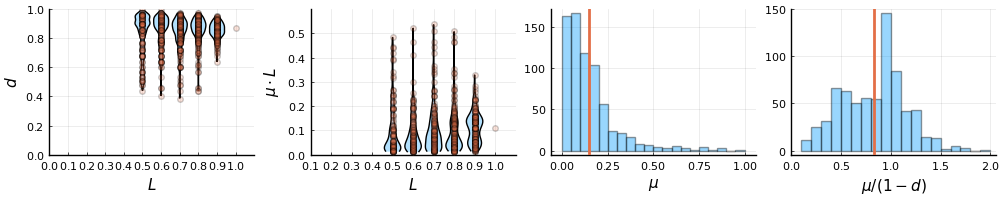

In [164]:
params = (
    f_min = 1/20,
    Nthresh_orph =90,
    Nthresh_estr = 90,
    )

freqs = SeqDataFormatting.mfreqs(wes_init) |> df -> Dict( df.mutation .=> df.frequency)
mutations = union(wes_init.mutations...)
results = Vector()
Ls = Float64[]
for L = 0.5:0.1:1.
    for _=1:200
        tumor = deepcopy(select(wes, :mutations))
        
        selection = sample(mutations, floor(Int, length(mutations)*L), replace =false)
        filter!.(m -> m in selection, tumor.mutations)
        
        # freqs = TumorGrowth.mutation_freqs(tumor) |> df -> Dict( df.mutation .=> df.frequency)
        
        # filter!.(m-> 1.1 > freqs[m] > params[:f_min], tumor.mutations)

        htypes = unique(tumor.mutations)
        orphaned_tumor = DataFrame( mutations = unique( 
                filter.(m-> freqs[m] > params[:f_min], htypes) ) )
        estranged_tumor = DataFrame(mutations = filter( 
                muts -> all(  freqs[m] > params[:f_min] for m in muts), htypes) )

        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |>
            df -> sum(df.isorphaned)/sum(df.isgreen) 
        
        # d_solve = min(1., 2*log(params[:Nthresh_orph])*W_l)
        try
            d_solve = fzero(x -> min(1., Turnover.W_orphaned( x; 
                N= params[:Nthresh_orph] * (1-x))) - W_l,
                0.01, 0.99)
        catch e
            d_solve = 1
        end
        
        (isnan(d_solve) || isone(d_solve) || iszero(d_solve)) && continue
        
        # get mu
        W_c = estranged_treeless(estranged_tumor) |> 
            df -> sum(df.isestranged)/sum(df.isgreen) 
        try
#             mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, 
                        T=log(params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, 0.01, 0.99)
            mu_solve ≈ 0.99 && continue
            
            push!(results, (d_solve, mu_solve))
            push!(Ls, L)
            L==1. && break
            catch e
        end
        
    end
end
p = plot(layout=(1,4), legend=:none, size=(1000,200))
scalex = 10

violin!(p[1], scalex*Ls, getindex.(results,1), fillalpha=0.3, xticks = ([0:scalex;], [(0:scalex) ./ scalex;]))
scatter!(p[1], scalex*Ls, getindex.(results, 1), alpha=0.2, xlim=(0,scalex*1.1), ylim=(0,1), xlab = L"L", ylab=L"d")
# hline!(p[1], [mean(getindex.(results, 1))], lw=2.)

violin!(p[2], scalex*Ls, getindex.(results,2), fillalpha=0.3, xticks = ([1:scalex;], [(1:scalex) ./ scalex;]))
scatter!(p[2], scalex*Ls, getindex.(results, 2), alpha=0.2, xlim=(4,scalex+1), ylim=(0,0.6), xlab = L"L", ylab=L"\mu\cdot L")
# plot!(p[2], [0,scalex], [0,last(results)[2]], lw=2.)

histogram!(p[3], getindex.(results, 2)./Ls, nbins=30, alpha=0.4, xlab = L"\mu")
vline!(p[3], [mean(getindex.(results, 2)./Ls)], lw=2. )

slope = filter(x -> x< 4, getindex.(results, 2)./Ls ./ (1 .- getindex.(results, 1)))

histogram!(p[4], slope, xlim=(0,:auto), nbins=30, alpha=0.4 , xlab = L"\mu/(1-d)")
vline!(p[4], [mean(slope)], lw=2. )